<h1> CLASSIFICATION OF PNEUMONIA IN CHEST X-RAY IMAGES USING CNNs</h1><br>
<b style = 'font-size: 16px;'>Deligiannis Panagiotis</b><br>
AEM: 2022202004004<br>
<a href = "mailto: dit2004dsc@office365.uop.gr">MAIL</a><br>
<b style = 'font-size: 16px;'>Tzerefos Anargiros</b><br>
AEM: 2022202004022<br>
<a href = "mailto: dit2022dsc@office365.uop.gr">MAIL</a><br>

<h2> Scope </h2>
The scope of this project is to classify Pneumonia cases by training a Convolutional Neural Network using chest X-ray images as a dataset. 

<h2> Dataset </h2>
The dataset, downloaded from <a href = "https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia">kaggle</a> consists of 5,863 chest X-Ray images (JPEG) taken from pediatric patients in Guangzhou Women and Children’s Medical Center, Guangzhou. The image cases are divided into 2 categories, Pneumonia and Normal ones.
The training dataset contains 5,216 images, the testing dataset contains 624 images and the validation 16 images.

<h2> Imports </h2>
Below are the imports necessary for our notebook to run.

In [121]:
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras.models import Sequential, load_model
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from keras.preprocessing.image import ImageDataGenerator, load_img
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau
import cv2
import os
import numpy as np

<h2> Data Loading </h2> <br>
    Initially we define a function that loads and resizes to 100 x 100 pixels every image for every
    subset. Since the images are variable in size, a resizing is deemed necessary and for complexity
    purposes, we have decided to opt for the aforementioned resolution.


In [122]:
labels = ['PNEUMONIA', 'NORMAL']
img_size = 100
training_path = 'datasets/archive/chest_xray/chest_xray/train'
testing_path = 'datasets/archive/chest_xray/chest_xray/test'
validation_path = 'datasets/archive/chest_xray/chest_xray/val'
model_save_path = 'model/'
def get_data(data_dir):
    data = [] 
    img_avg_pixels = 0
    img_cnt = 0
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return [np.array(data), img_avg_pixels]

<h2> Basic Visualizations </h2> <br>
    We get a more in depth view of our training, testing and validation datasets and their class distributions.
    We also get a taste of how Pneumonia and Normal X-rays look like.

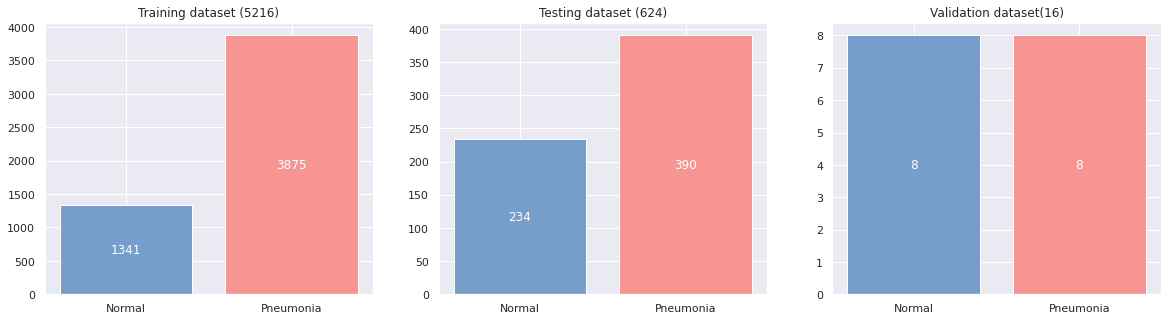

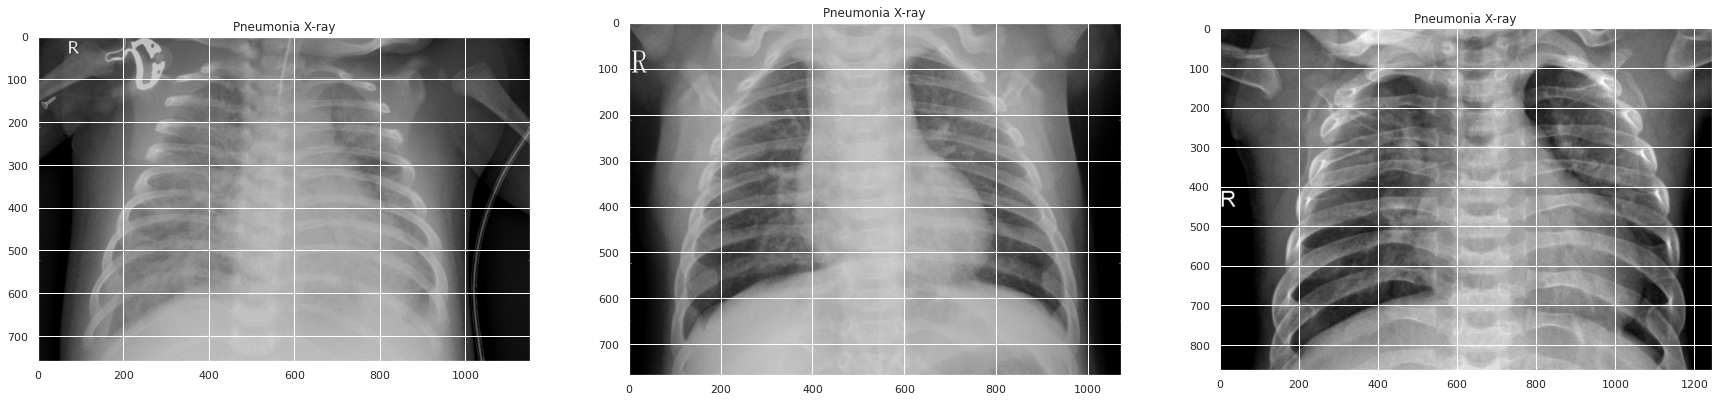

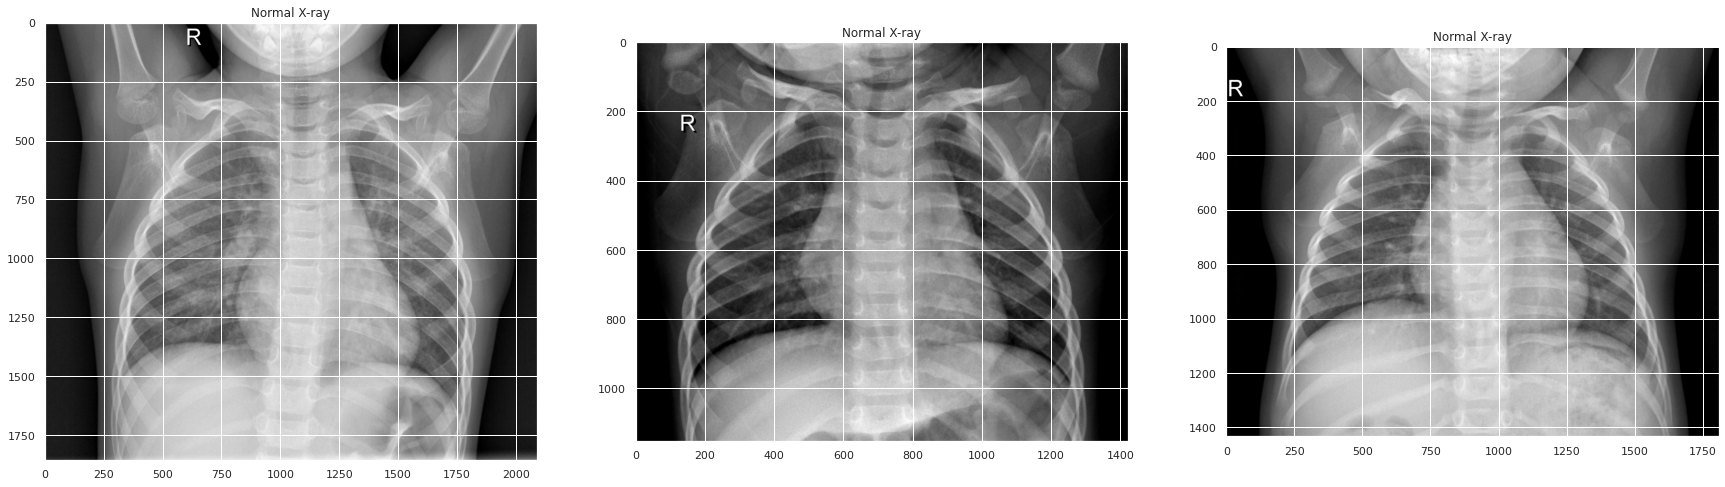

In [130]:
train_n_size = os.listdir(training_path+'/NORMAL')
train_p_size = os.listdir(training_path+'/PNEUMONIA')

test_n_size = os.listdir(testing_path+'/NORMAL')
test_p_size = os.listdir(testing_path+'/PNEUMONIA')

val_n_size = os.listdir(validation_path+'/NORMAL')
val_p_size = os.listdir(validation_path+'/PNEUMONIA')

fig,(ax1,ax2,ax3)=plt.subplots(1,3,figsize=(20,5))
p1 = ax1.bar(['Normal', 'Pneumonia'],[len(train_n_size), len(train_p_size)], color=['#779ECB', '#F69592'])
p2 = ax2.bar(['Normal', 'Pneumonia'],[len(test_n_size), len(test_p_size)], color=['#779ECB', '#F69592'])
p3 = ax3.bar(['Normal', 'Pneumonia'],[len(val_n_size), len(val_p_size)], color=['#779ECB', '#F69592'])
ax1.title.set_text('Training dataset (%d)' % ( len(train_n_size) + len(train_p_size) ))
ax2.title.set_text('Testing dataset (%d)' % ( len(test_n_size) + len(test_p_size) ))
ax3.title.set_text('Validation dataset(%d)' % ( len(val_n_size) + len(val_p_size) ))
ax1.bar_label(p1, label_type='center', color="white")
ax2.bar_label(p2, label_type='center', color="white")
ax3.bar_label(p3, label_type='center', color="white")
plt.show()

fig,(ax1,ax2,ax3)=plt.subplots(1,3,figsize=(30,10))
img_normal1=load_img(training_path+"/PNEUMONIA/"+train_p_size[0])
img_normal2=load_img(training_path+"/PNEUMONIA/"+train_p_size[1])
img_normal3=load_img(training_path+"/PNEUMONIA/"+train_p_size[2])
ax1.imshow(img_normal1)
ax2.imshow(img_normal2)
ax3.imshow(img_normal3)
ax1.title.set_text('Pneumonia X-ray')
ax2.title.set_text('Pneumonia X-ray')
ax3.title.set_text('Pneumonia X-ray')
plt.show()

fig,(ax1,ax2,ax3)=plt.subplots(1,3,figsize=(30,10))
img_normal1=load_img(training_path+"/NORMAL/"+train_n_size[0])
img_normal2=load_img(training_path+"/NORMAL/"+train_n_size[1])
img_normal3=load_img(training_path+"/NORMAL/"+train_n_size[2])
ax1.imshow(img_normal1)
ax2.imshow(img_normal2)
ax3.imshow(img_normal3)
ax1.title.set_text('Normal X-ray')
ax2.title.set_text('Normal X-ray')
ax3.title.set_text('Normal X-ray')
plt.show()

In [124]:
train = get_data(training_path)
test = get_data(testing_path)
val = get_data(validation_path)

<ipython-input-122-f460998edaf3>:21: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return [np.array(data), img_avg_pixels]


<h2> Data Preprocessing </h2> <br>
    After loading the resized images, we create our training, testing and validataion datasets along with
    their respective labels. We assign <b>Pneumonia</b> cases with label 0 and <b>Normal</b> cases with label 1. <br>

In [125]:
train = train[0]
test = test[0]
val = val[0]

x_train = []
y_train = []

x_val = []
y_val = []

x_test = []
y_test = []

for feature, label in train:
    x_train.append(feature)
    y_train.append(label)

for feature, label in test:
    x_test.append(feature)
    y_test.append(label)
    
for feature, label in val:
    x_val.append(feature)
    y_val.append(label)

<h2> Image Normalization </h2> <br>
    We normalize pixel values for each image into the range [0-1], in order to reduce the model's complexity and aid with the calculations <br>

In [126]:
# NORMALIZE IMAGE PIXELS VALUES
x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255
x_test = np.array(x_test) / 255

# RESIZE DATA FOR DEEP LEARNING
x_train = x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_val = x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

x_test = x_test.reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test)


<h2> Image Augmentation </h2><br>
    We create an image generator which will create a balanced batch size during each
    Neural Network epoch. The images generated will differ slightly, in order to prevent
    overfitting and combat class imbalance, with the usage of techniques like image flipping, zooming and rotating.

In [127]:
datagen = ImageDataGenerator(
          rotation_range = 30,  # randomly rotate image. val = Degree range for random rotations.
          zoom_range = 0.2, # Float or [lower, upper]. Range for random zoom. If a float, [lower, upper] = [1-zoom_range, 1+zoom_range].
          width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
          height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
          horizontal_flip = True)  # randomly flip images

datagen.fit(x_train)

<h2> Model Layers </h2>
<b>1) Conv2D</b> <br>
    This layer creates a convolution kernel that is convolved with the layer input to produce a tensor of outputs.<br>
<b>2) MaxPool2D</b> <br> 
    Downsamples the input along its spatial dimensions (height and width) by taking the maximum value over an input window (of size defined by pool_size) for each channel of the input. The window is shifted by strides along each dimension. <br>
<b>3) Dropout</b> <br>
    The Dropout layer randomly sets input units to 0 with a frequency of rate at each step during training time, which helps prevent overfitting. Inputs not set to 0 are scaled up by 1/(1 - rate) such that the sum over all inputs is unchanged.<br>
<b>4) Flatten</b> <br>
    Flattens the input. Does not affect the batch size. <br> E.g. (1, 10, 64) => (640)<br>
<b>5) Dense</b> <br>
    Just your regular densely-connected NN layer.<br>
<b>6) Batch Normalization</b><br>
    Batch normalization applies a transformation that maintains the mean output close to 0 and the output standard deviation close to 1.<br>

In [128]:
epochs = 12

model = Sequential()

model.add(Conv2D(32 , (3,3), strides = 1, padding = 'same', activation = 'relu', input_shape = (img_size, img_size, 1)))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(64 , (3,3), strides = 1, padding = 'same', activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.1))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(64 , (3,3), strides = 1, padding = 'same', activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

model.add(Flatten())  

model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(units = 1 , activation = 'sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['binary_accuracy'])
display(model.summary())

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_25 (Conv2D)           (None, 100, 100, 32)      320       
_________________________________________________________________
batch_normalization_25 (Batc (None, 100, 100, 32)      128       
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 50, 50, 32)        0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 50, 50, 64)        18496     
_________________________________________________________________
batch_normalization_26 (Batc (None, 50, 50, 64)        256       
_________________________________________________________________
dropout_18 (Dropout)         (None, 50, 50, 64)        0         
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 25, 25, 64)       

None

<h2> Callback Function </h2>
A callback is an object that can perform actions at various stages of training. In our case we will use ReduceLROnPlateau, which is a callback that reduces learning rate when a metric has stopped improving. With the callback we monitor the validation binary accuracy of our model and we essentialy reduce the learning rate periodically after a predefined number of epochs has passed in which the accuracy does not seem to improve.<br>

More specifically, every 2 <b>epochs</b> we reduce the <b>learning rate</b> by 0.2 if the accuracy has not improved. The <b>minimum learning rate</b> we can reach is set to be at 0.0000001.<br>

In [129]:
callback = ReduceLROnPlateau(
        monitor='val_binary_accuracy', #MONITOR ACCURACY 
        factor=0.2,
        verbose = 2,
        patience=2, 
        min_lr=0.0000001)
model_var = model.fit(
    datagen.flow(x_train,y_train, batch_size = 32), 
    epochs=epochs, 
    validation_data = datagen.flow(x_val, y_val),
    callbacks = callback)

Epoch 1/12
163/163 [==============================] - 47s 284ms/step - loss: 0.7106 - binary_accuracy: 0.8044 - val_loss: 28.5331 - val_binary_accuracy: 0.5000
Epoch 2/12
163/163 [==============================] - 50s 304ms/step - loss: 0.2800 - binary_accuracy: 0.8927 - val_loss: 61.1525 - val_binary_accuracy: 0.5000
Epoch 3/12
163/163 [==============================] - 48s 296ms/step - loss: 0.2439 - binary_accuracy: 0.9097 - val_loss: 49.4219 - val_binary_accuracy: 0.5000

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
Epoch 4/12
163/163 [==============================] - 49s 300ms/step - loss: 0.1585 - binary_accuracy: 0.9403 - val_loss: 13.7893 - val_binary_accuracy: 0.5000
Epoch 5/12
163/163 [==============================] - 48s 293ms/step - loss: 0.1370 - binary_accuracy: 0.9550 - val_loss: 6.9600 - val_binary_accuracy: 0.5625
Epoch 6/12
163/163 [==============================] - 50s 304ms/step - loss: 0.1149 - binary_accuracy: 0.9590 - val_los

In [131]:
model.save(model_save_path+'/chest-xray.h5')
# model = load_model(model_save_path+'/chest-xray.h5')
print("Loss: " , model.evaluate(x_test,y_test)[0])
print("Accuracy: " , model.evaluate(x_test,y_test)[1]*100 , "%")

20/20 [==============================] - 1s 68ms/step - loss: 0.2863 - binary_accuracy: 0.9135
Loss:  0.28629034757614136
20/20 [==============================] - 2s 87ms/step - loss: 0.2863 - binary_accuracy: 0.9135
Accuracy:  91.34615659713745 %


<h2> Display Accuracies & Loss </h2>
    Below we display our model's training and validation accuracy and loss

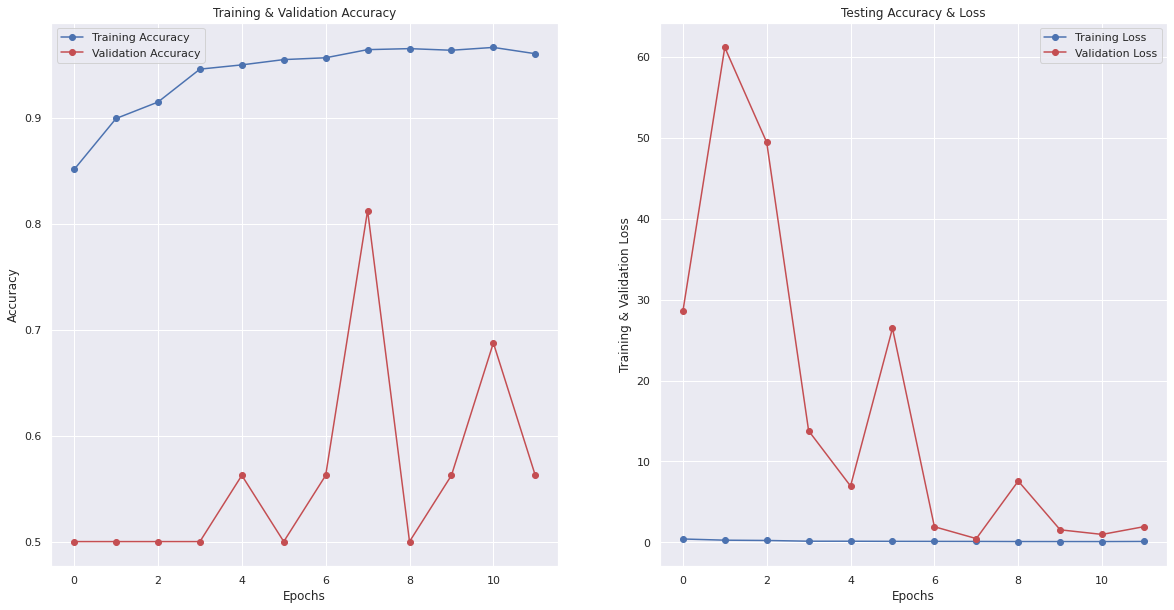

In [132]:
sns.set()
epochs = [i for i in range(epochs)]
fig , ax = plt.subplots(1,2)
train_acc = model_var.history['binary_accuracy'] #accuracy
train_loss = model_var.history['loss']
val_acc = model_var.history['val_binary_accuracy'] # val_accuracy
val_loss = model_var.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'bo-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'b-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Training & Validation Loss")
plt.show()

In [133]:
predictions = model.predict_classes(x_test)
predictions = predictions.reshape(1,-1)[0]

/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


<h2> Classification Report </h2>
    Following our model's predictions, we illustrate a classification report which demonstrates precision, recall, f1-score and support for each of the two classes.

                     precision    recall  f1-score   support

Pneumonia (Class 0)       0.90      0.96      0.93       390
   Normal (Class 1)       0.93      0.83      0.88       234

           accuracy                           0.91       624
          macro avg       0.92      0.90      0.91       624
       weighted avg       0.91      0.91      0.91       624



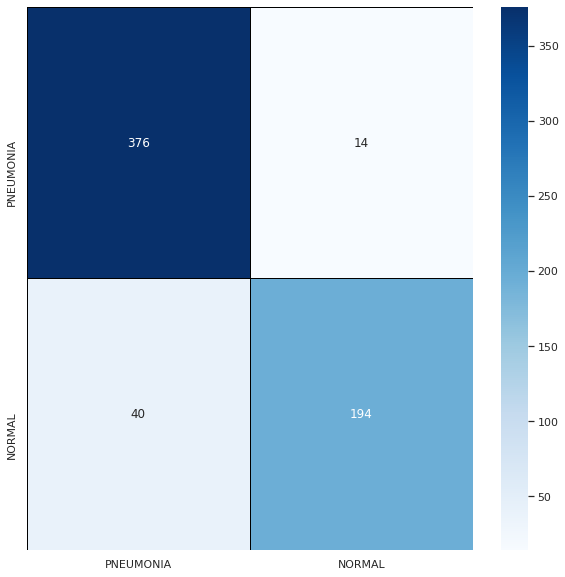

In [134]:
print(classification_report(y_test, predictions, target_names = ['Pneumonia (Class 0)','Normal (Class 1)']))
cm = confusion_matrix(y_test,predictions)
plt.figure(figsize = (10,10))
sns.heatmap(
    cm,cmap= "Blues", 
    linecolor = 'black' , 
    linewidth = 1 , 
    annot = True, 
    fmt='',
    xticklabels = labels,
    yticklabels = labels)
plt.show()

In [135]:
correct = np.nonzero(predictions == y_test)[0]
incorrect = np.nonzero(predictions != y_test)[0]

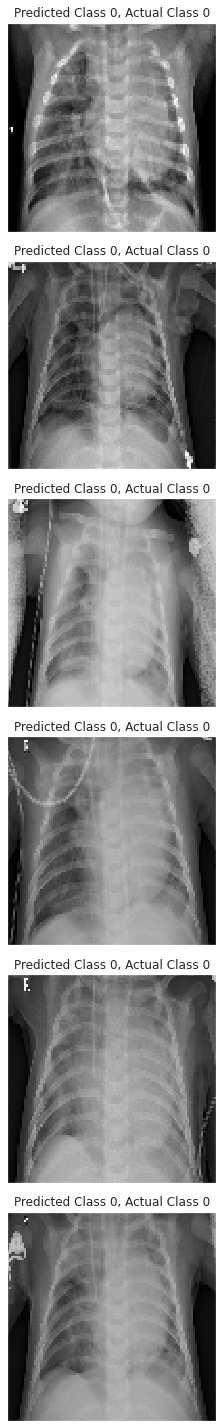

In [136]:
i = 0
sns.set()
plt.figure(figsize=(20,20))
for c in correct[:6]:
    plt.subplot(6,1,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_test[c].reshape(100,100), cmap="gray", interpolation='none')
    plt.title("Predicted Class {}, Actual Class {}".format(predictions[c], y_test[c]))
    plt.tight_layout()
    i += 1

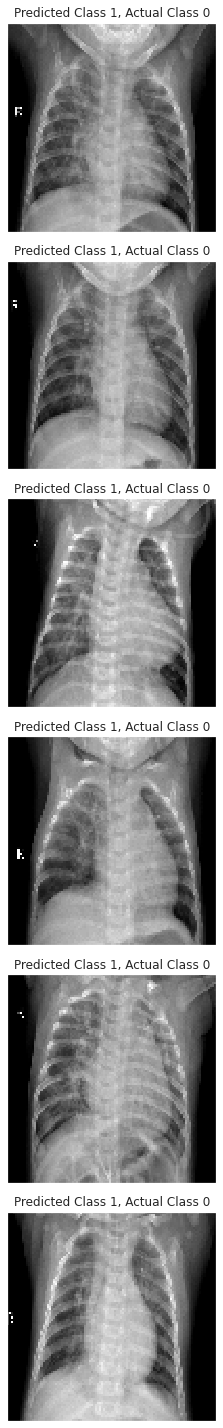

In [137]:
i = 0
sns.set()
plt.figure(figsize=(20,20))
for c in incorrect[:6]:
    plt.subplot(6,1,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_test[c].reshape(100,100), cmap="gray", interpolation='none')
    plt.title("Predicted Class {}, Actual Class {}".format(predictions[c], y_test[c]))
    plt.tight_layout()
    i += 1